7/2 - 6/22 to 6/28 processed as first file (no data for 6/24)


In [1]:
import os
import json
import numpy as np
import pandas as pd
import pyarrow as pa
from pandas.io.json import json_normalize
import cryptography
import nltk
nltk.download('punkt')
nltk.download('stopwords')
import matplotlib.pyplot as plt
import re
from cryptography.fernet import Fernet
import bs4

[nltk_data] Downloading package punkt to /home/ubuntu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/ubuntu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
#files = os.listdir('/data/data/2019-06-10/enrichment/fetch_page')
dates = os.listdir('/data/data')[-7:-6]
print(dates)
dfs = []
file_names = []
unsafe = []
for date in dates:
    try:
        files = os.listdir('/data/data/'+date+'/enrichment/fetch_page')
        for i in range(len(files)):
            try:
                with open('/data/data/'+date+'/enrichment/fetch_page/'+files[i]) as d:
                    try:
                        r = json.load(d)
                        temp_df = json_normalize(r['data'])
                        temp_df['from_file'] = [files[i]]*temp_df.shape[0]
                        if len(files[i]) > 7:
                            temp_df['unsafe'] = [1]*temp_df.shape[0]
                        else:
                            temp_df['unsafe'] = [0]*temp_df.shape[0]
                        dfs.append(temp_df)
                    except:
                        print(files[i])
            except:
                print(date+'!')
    except:
        print(date+'!')
    print(date)
all_fetch_df = pd.concat(dfs).reset_index(drop=True)
recent_df = pd.concat(dfs).reset_index(drop=True)
recent_df = recent_df[recent_df['success']]
#temp['from_file'] = file_names
#success_fetch_df = all_fetch_df[all_fetch_df['success']].reset_index(drop=True)
#success_fetch_df


['2019-07-22']
5d350ab1b7198a947f381a0b-1.json
5d350ab1b7198a947f381a0b.json
5d350bc710abdabf9d26d006-1.json
5d350bc710abdabf9d26d006.json
2019-07-22


In [3]:
recent_df = recent_df.reset_index(drop= True)

In [5]:
def decrypt_content(key_str, content_str):
    key = bytes(key_str, encoding='UTF-8')
    f = Fernet(key)
    text = f.decrypt(bytes(content_str, encoding='UTF-8'))
    print(str(text[:120]))
    if('This program cannot be run in DOS mode' in str(text[:200]) or '\x00\x00Android.mkm\xef\xbf\xbdA\x0b\xef\xbf\xbd0' in str(text[:200])
      or 'This program must be run under Win32' in str(text[:200])):
        try:
            return str(text)
        except:
            return 'Error'
    else:
        #print('preparing soup...')
        soup = bs4.BeautifulSoup(text,'lxml')
        try:
            return soup.prettify()
        except:
            print('PROBLEM')
            return str(text)

#skipped 3862 as it gave memory error
html_str = recent_df['page_content'].copy()
print(len(html_str))
for i in range(len(html_str)): 
    print(html_str[0])
    html_str.iloc[0] = decrypt_content(recent_df.loc[0,'encryption_key'],recent_df.loc[0,'page_content'])

html_str[0]

1203


KeyError: 0

In [7]:
len(html_str)

1357

IndexError: boolean index did not match indexed array along dimension 0; dimension is 8470 but corresponding boolean dimension is 1

In [24]:
fetch_df = recent_df

fetch_df['decoded'] = html_str
fetch_df['raw_len'] = html_str.str.len()

In [ ]:
fetch_df.to_pickle('fetch_6_27.gzip', compression = 'gzip')

In [3]:
fetch_df2 = pd.read_pickle('fetch_6_28.gzip')
fetch_df2

KeyError: 31

In [ ]:
all_dfs += [fetch_df2]


In [144]:
#need to get whatever info I'm planning to get from the tags within the code before I strip them out
    #  <a> ; img ; meta ; script ; source  ; style ; charset / encoding; embed ; form ; link
    # <a ... ></a> attributes that could be relevant at a glance : download, ping, target
# regex defining the a tag
a_tag_pattern = re.compile(r'<\s*\/\s*a\s*>') #matches closing tags
script_tag_pattern = re.compile(r'</script>') #matches closing tags
meta_tag_pattern = re.compile(r'<\s*meta ((charset|content|http-equiv|name|scheme)\s*=.*){0,5}>')
style_tag_pattern = re.compile(r'<\s*\/\s*style\s*>') #matches closing tags
img_tag_pattern = re.compile(r'<\s*img .*>|<\s*source [^>]* srcset\s*=\s*.*\s*>')
fetch_df.replace(None, 'None')
raw_str = fetch_df['decoded']
fetch_df['a_count'] = raw_str.apply(lambda x: len(re.findall(a_tag_pattern,x)))
fetch_df['script_count'] = raw_str.apply(lambda x: len(re.findall(script_tag_pattern,x)))
fetch_df['meta_count'] = raw_str.apply(lambda x: len(re.findall(meta_tag_pattern,x)))
fetch_df['style_count'] = raw_str.apply(lambda x: len(re.findall(style_tag_pattern,x)))
fetch_df['img_count'] = raw_str.apply(lambda x: len(re.findall(img_tag_pattern,x)))
fetch_df.tail(50)

TypeError: 'regex' must be a string or a compiled regular expression or a list or dict of strings or regular expressions, you passed a 'bool'

In [10]:

#fetch_df['clean_len'] = html_str.map(lambda x: bs4.BeautifulSoup(x,"lxml").get_text())
def strip_tags(decoded):
        soup = bs4.BeautifulSoup(decoded,'lxml')
        return soup.get_text()
    
fetch_df['clean'] = html_str.apply(strip_tags)
fetch_df['clean_len'] = fetch_df['clean'].apply(lambda x: len(x))
fetch_df


,encryption_key,from_file,indicator,page_content,status_code,success,unsafe,url,user-agent,decoded,raw_len,a_count,script_count,meta_count,style_count,img_count,clean,clean_len
0,jpYB0CUM5TDQV3gea8M75cE0tULe0_6hmpZOh5UH5-Y=,0.json,http://urdupoint.com,gAAAAABdDu5MyiU4EpQRzTNm0qidQCVjS95Q0fuLyzTtjq...,403.0,True,0,http://urdupoint.com/,"Mozilla/5.0 (compatible, MSIE 11, Windows NT 6...",<!DOCTYPE html>\n<!--[if lt IE 7]> <html class...,3367,1,3,5,1,0,\n\n\n\n Access denied | urdupoint.com used ...,759
1,jpYB0CUM5TDQV3gea8M75cE0tULe0_6hmpZOh5UH5-Y=,0.json,http://oload.space,gAAAAABdDu5NyRHeOjyXFtJiiiObpJTfGtGhWMkNAC8cBA...,403.0,True,0,http://oload.space/,"Mozilla/5.0 (compatible, MSIE 11, Windows NT 6...",<!DOCTYPE html>\n<!--[if lt IE 7]> <html class...,3363,1,3,5,1,0,\n\n\n\n Access denied | oload.space used Cl...,755
2,jpYB0CUM5TDQV3gea8M75cE0tULe0_6hmpZOh5UH5-Y=,0.json,http://vesti.ru,gAAAAABdDu5OBSNOfVEriIQKT4af3e7iHEUyXSh8nDYGm3...,200.0,True,0,http://www.vesti.ru/,"Mozilla/5.0 (compatible, MSIE 11, Windows NT 6...",<!DOCTYPE html>\n<html>\n <head>\n <meta char...,123319,321,56,18,2,63,"\n\n\n\n\n\n Вести.Ru: новости, видео и фото...",43693
3,jpYB0CUM5TDQV3gea8M75cE0tULe0_6hmpZOh5UH5-Y=,0.json,http://delta.com,gAAAAABdDu5OgS6_tBDpElTiWXBZrwDXY0ZcEpCUzRin1K...,403.0,True,0,https://www.delta.com,"Mozilla/5.0 (compatible, MSIE 11, Windows NT 6...",<html>\n <head>\n <title>\n Access Denied\n...,256,0,0,0,0,0,\n\n\n Access Denied\n \n\n\n\n Access De...,178
4,jpYB0CUM5TDQV3gea8M75cE0tULe0_6hmpZOh5UH5-Y=,0.json,http://investopedia.com,gAAAAABdDu5PFvrcqz0a6N0AvXyxTJ-7BtDiAFFmVjcyxJ...,200.0,True,0,https://www.investopedia.com/,"Mozilla/5.0 (compatible, MSIE 11, Windows NT 6...","<!DOCTYPE html>\n<html class=""comp homeTemplat...",134402,141,7,25,12,12,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,19329
5,jpYB0CUM5TDQV3gea8M75cE0tULe0_6hmpZOh5UH5-Y=,0.json,http://taimienphi.vn,gAAAAABdDu5QAzldK62Hp_7H3Qc_DxxTeQOmqgyTsR4Rnn...,200.0,True,0,http://taimienphi.vn/,"Mozilla/5.0 (compatible, MSIE 11, Windows NT 6...","<!DOCTYPE html PUBLIC ""-//W3C//DTD XHTML 1.0 T...",103380,332,10,4,0,24,\n\n\n\n\n\n\n\n\n\n\n Download - Tải Miễn P...,36667
6,jpYB0CUM5TDQV3gea8M75cE0tULe0_6hmpZOh5UH5-Y=,0.json,http://mynet.com,gAAAAABdDu5Qhq9Xjnysqyagxcr-X-_jh2coVDHQutcEXP...,200.0,True,0,https://www.mynet.com/,"Mozilla/5.0 (compatible, MSIE 11, Windows NT 6...","<!DOCTYPE html>\n<html lang=""tr-TR"">\n <head>\...",231573,284,16,15,0,149,"\n\n\n\n\n\n\n Mynet | Haber, Oyun, Video, S...",95942
7,jpYB0CUM5TDQV3gea8M75cE0tULe0_6hmpZOh5UH5-Y=,0.json,http://forbes.com,gAAAAABdDu5Qs6NFKTVdrskLFn6xgTpJHb7L8Uc1bBkp3z...,200.0,True,0,https://www.forbes.com/,"Mozilla/5.0 (compatible, MSIE 11, Windows NT 6...","<!DOCTYPE html>\n<html lang=""en"">\n <head>\n ...",490418,299,9,20,2,0,\n\n\n\n\n\n Forbes\n \n\n\n\n\n\n\n\n\n\n\...,393150
8,jpYB0CUM5TDQV3gea8M75cE0tULe0_6hmpZOh5UH5-Y=,0.json,http://iqoption.com,gAAAAABdDu5Qg5c5yPEhEFBQAOFii1JXDZBtHuvaCn4uWa...,200.0,True,0,https://iqoption.com/en,"Mozilla/5.0 (compatible, MSIE 11, Windows NT 6...",<!DOCTYPE html>\n<html>\n <head>\n <title>\n ...,21714,0,5,19,2,2,\n\n\n IQ Option\n \n\n\n\n\n\n\n\n\n\n\n\n...,16583
9,jpYB0CUM5TDQV3gea8M75cE0tULe0_6hmpZOh5UH5-Y=,0.json,http://4chan.org,gAAAAABdDu5QI2ZNrf9PDB_NUH8zTSkR-4JoEvJm2-spAV...,403.0,True,0,http://4chan.org/,"Mozilla/5.0 (compatible, MSIE 11, Windows NT 6...","<!DOCTYPE html PUBLIC ""-//W3C//DTD XHTML 1.0 S...",17324,1,0,6,1,0,\n\n\n\n\n\n\n\n\n 4chan - Error\n \n\n h...,15928


In [18]:
fetch_df['tag_len'] = fetch_df['raw_len'] - fetch_df['clean_len']
fetch_df

,encryption_key,from_file,indicator,page_content,status_code,success,unsafe,url,user-agent,decoded,raw_len,a_count,script_count,meta_count,style_count,img_count,clean,clean_len,tag_len
0,jpYB0CUM5TDQV3gea8M75cE0tULe0_6hmpZOh5UH5-Y=,0.json,http://urdupoint.com,gAAAAABdDu5MyiU4EpQRzTNm0qidQCVjS95Q0fuLyzTtjq...,403.0,True,0,http://urdupoint.com/,"Mozilla/5.0 (compatible, MSIE 11, Windows NT 6...",<!DOCTYPE html>\n<!--[if lt IE 7]> <html class...,3367,1,3,5,1,0,\n\n\n\n Access denied | urdupoint.com used ...,759,2608
1,jpYB0CUM5TDQV3gea8M75cE0tULe0_6hmpZOh5UH5-Y=,0.json,http://oload.space,gAAAAABdDu5NyRHeOjyXFtJiiiObpJTfGtGhWMkNAC8cBA...,403.0,True,0,http://oload.space/,"Mozilla/5.0 (compatible, MSIE 11, Windows NT 6...",<!DOCTYPE html>\n<!--[if lt IE 7]> <html class...,3363,1,3,5,1,0,\n\n\n\n Access denied | oload.space used Cl...,755,2608
2,jpYB0CUM5TDQV3gea8M75cE0tULe0_6hmpZOh5UH5-Y=,0.json,http://vesti.ru,gAAAAABdDu5OBSNOfVEriIQKT4af3e7iHEUyXSh8nDYGm3...,200.0,True,0,http://www.vesti.ru/,"Mozilla/5.0 (compatible, MSIE 11, Windows NT 6...",<!DOCTYPE html>\n<html>\n <head>\n <meta char...,123319,321,56,18,2,63,"\n\n\n\n\n\n Вести.Ru: новости, видео и фото...",43693,79626
3,jpYB0CUM5TDQV3gea8M75cE0tULe0_6hmpZOh5UH5-Y=,0.json,http://delta.com,gAAAAABdDu5OgS6_tBDpElTiWXBZrwDXY0ZcEpCUzRin1K...,403.0,True,0,https://www.delta.com,"Mozilla/5.0 (compatible, MSIE 11, Windows NT 6...",<html>\n <head>\n <title>\n Access Denied\n...,256,0,0,0,0,0,\n\n\n Access Denied\n \n\n\n\n Access De...,178,78
4,jpYB0CUM5TDQV3gea8M75cE0tULe0_6hmpZOh5UH5-Y=,0.json,http://investopedia.com,gAAAAABdDu5PFvrcqz0a6N0AvXyxTJ-7BtDiAFFmVjcyxJ...,200.0,True,0,https://www.investopedia.com/,"Mozilla/5.0 (compatible, MSIE 11, Windows NT 6...","<!DOCTYPE html>\n<html class=""comp homeTemplat...",134402,141,7,25,12,12,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,19329,115073
5,jpYB0CUM5TDQV3gea8M75cE0tULe0_6hmpZOh5UH5-Y=,0.json,http://taimienphi.vn,gAAAAABdDu5QAzldK62Hp_7H3Qc_DxxTeQOmqgyTsR4Rnn...,200.0,True,0,http://taimienphi.vn/,"Mozilla/5.0 (compatible, MSIE 11, Windows NT 6...","<!DOCTYPE html PUBLIC ""-//W3C//DTD XHTML 1.0 T...",103380,332,10,4,0,24,\n\n\n\n\n\n\n\n\n\n\n Download - Tải Miễn P...,36667,66713
6,jpYB0CUM5TDQV3gea8M75cE0tULe0_6hmpZOh5UH5-Y=,0.json,http://mynet.com,gAAAAABdDu5Qhq9Xjnysqyagxcr-X-_jh2coVDHQutcEXP...,200.0,True,0,https://www.mynet.com/,"Mozilla/5.0 (compatible, MSIE 11, Windows NT 6...","<!DOCTYPE html>\n<html lang=""tr-TR"">\n <head>\...",231573,284,16,15,0,149,"\n\n\n\n\n\n\n Mynet | Haber, Oyun, Video, S...",95942,135631
7,jpYB0CUM5TDQV3gea8M75cE0tULe0_6hmpZOh5UH5-Y=,0.json,http://forbes.com,gAAAAABdDu5Qs6NFKTVdrskLFn6xgTpJHb7L8Uc1bBkp3z...,200.0,True,0,https://www.forbes.com/,"Mozilla/5.0 (compatible, MSIE 11, Windows NT 6...","<!DOCTYPE html>\n<html lang=""en"">\n <head>\n ...",490418,299,9,20,2,0,\n\n\n\n\n\n Forbes\n \n\n\n\n\n\n\n\n\n\n\...,393150,97268
8,jpYB0CUM5TDQV3gea8M75cE0tULe0_6hmpZOh5UH5-Y=,0.json,http://iqoption.com,gAAAAABdDu5Qg5c5yPEhEFBQAOFii1JXDZBtHuvaCn4uWa...,200.0,True,0,https://iqoption.com/en,"Mozilla/5.0 (compatible, MSIE 11, Windows NT 6...",<!DOCTYPE html>\n<html>\n <head>\n <title>\n ...,21714,0,5,19,2,2,\n\n\n IQ Option\n \n\n\n\n\n\n\n\n\n\n\n\n...,16583,5131
9,jpYB0CUM5TDQV3gea8M75cE0tULe0_6hmpZOh5UH5-Y=,0.json,http://4chan.org,gAAAAABdDu5QI2ZNrf9PDB_NUH8zTSkR-4JoEvJm2-spAV...,403.0,True,0,http://4chan.org/,"Mozilla/5.0 (compatible, MSIE 11, Windows NT 6...","<!DOCTYPE html PUBLIC ""-//W3C//DTD XHTML 1.0 S...",17324,1,0,6,1,0,\n\n\n\n\n\n\n\n\n 4chan - Error\n \n\n h...,15928,1396


In [27]:
fetch_df[fetch_df['unsafe']==0]['indicator'].drop_duplicates()

0             http://urdupoint.com
1               http://oload.space
2                  http://vesti.ru
3                 http://delta.com
4          http://investopedia.com
5             http://taimienphi.vn
6                 http://mynet.com
7                http://forbes.com
8              http://iqoption.com
9                 http://4chan.org
10              http://pngtree.com
11              http://xvideos.com
12            http://gmarket.co.kr
13                 http://tempo.co
14               http://kotaku.com
15               http://feedly.com
16                http://fedex.com
17               http://redfin.com
18                 http://setn.com
19               http://argaam.com
20         http://secureserver.net
21          http://pages.tmall.com
22              http://vseigru.net
23          http://list-manage.com
24               http://dnevnik.ru
25               http://elmundo.es
26                  http://mail.ru
27                http://chegg.com
28            http:/

In [52]:
temp_df = fetch_df.groupby(['indicator'],as_index=False).first()
temp_df

,indicator,encryption_key,from_file,page_content,status_code,success,unsafe,url,user-agent,decoded,raw_len,a_count,script_count,meta_count,style_count,img_count,clean,clean_len,tag_len
0,http://0.tcp.ngrok.io,jpYB0CUM5TDQV3gea8M75cE0tULe0_6hmpZOh5UH5-Y=,5d0d7da94cdd3bc1dfbe5fc8.json,gAAAAABdEGNJb0GIa29k91SynV50TuhLY9GOdHuQbnCTmt...,404.0,True,1,http://0.tcp.ngrok.io/,"Mozilla/5.0 (compatible, MSIE 11, Windows NT 6...",<html>\n <body>\n <p>\n Tunnel 0.tcp.ngrok....,79,0,0,0,0,0,\n\n\n Tunnel 0.tcp.ngrok.io not found\n \n\n,42,37
1,http://007akin.top,jpYB0CUM5TDQV3gea8M75cE0tULe0_6hmpZOh5UH5-Y=,5d0c2c2895de077813e0d437.json,gAAAAABdDwfkm4GpbqGenM5Tk5nEFjcuGYiQbgF7qd5Zgy...,403.0,True,1,http://007akin.top/,"Mozilla/5.0 (compatible, MSIE 11, Windows NT 6...","<!DOCTYPE HTML>\n<html lang=""en-US"">\n <head>\...",13213,36,1,9,1,0,\n\n\n\n\n\n\n\n\n\n\n\n Waiting for the red...,6960,6253
2,http://05184c3f62c5e20a1980bcb20042b059.co.cc,jpYB0CUM5TDQV3gea8M75cE0tULe0_6hmpZOh5UH5-Y=,5d10117d6b2fe25f5094a34e.json,gAAAAABdEaIVqr1iUbBnNQGGWxbmWpVkiaWPSLencNCKp4...,503.0,True,1,http://05184c3f62c5e20a1980bcb20042b059.co.cc/,"Mozilla/5.0 (compatible, MSIE 11, Windows NT 6...","<html>\n <head>\n <meta content=""always"" name...",265,0,1,2,0,0,\n\n\n\n\n\n\n\n\n\n window.opener = null; lo...,72,193
3,http://05184c3f62c5e20a1980bcb20042b059.cz.cc,jpYB0CUM5TDQV3gea8M75cE0tULe0_6hmpZOh5UH5-Y=,5d10117d6b2fe25f5094a34e.json,gAAAAABdEaIZImmdnK3xAEPIxxVcNbcJ-FNPZ0oNPr8aFe...,200.0,True,1,https://166686.com,"Mozilla/5.0 (compatible, MSIE 11, Windows NT 6...","<!DOCTYPE html PUBLIC ""-//W3C//DTD XHTML 1.0 T...",2133,0,4,4,1,1,\n\n\n if(/Android|webOS|iPhone|iPod|iPad|Bl...,855,1278
4,http://0531fb71aab2525aeba90a4619e5b7f7.cz.cc,jpYB0CUM5TDQV3gea8M75cE0tULe0_6hmpZOh5UH5-Y=,5d0ebfe250103dd059be5fc8.json,gAAAAABdEE6KZS0yfKUo_8gGQTXIdtjE_T9iEhv_9I8g6c...,200.0,True,1,https://166686.com,"Mozilla/5.0 (compatible, MSIE 11, Windows NT 6...","<!DOCTYPE html PUBLIC ""-//W3C//DTD XHTML 1.0 T...",2133,0,4,4,1,1,\n\n\n if(/Android|webOS|iPhone|iPod|iPad|Bl...,855,1278
5,http://05f00f69ed907a18f930fd18688aaa7b.co.cc,jpYB0CUM5TDQV3gea8M75cE0tULe0_6hmpZOh5UH5-Y=,5d0ebfe250103dd059be5fc8.json,gAAAAABdEE6IBWztgi7APe14tNHxVBkgF6ixg3_quSdp_B...,503.0,True,1,http://05f00f69ed907a18f930fd18688aaa7b.co.cc/,"Mozilla/5.0 (compatible, MSIE 11, Windows NT 6...","<html>\n <head>\n <meta content=""always"" name...",265,0,1,2,0,0,\n\n\n\n\n\n\n\n\n\n window.opener = null; lo...,72,193
6,http://05f00f69ed907a18f930fd18688aaa7b.cz.cc,jpYB0CUM5TDQV3gea8M75cE0tULe0_6hmpZOh5UH5-Y=,5d0ebfe250103dd059be5fc8.json,gAAAAABdEE6Kxb3cXS-Ddd01UeY3RicF79y3sA8GiooNoz...,200.0,True,1,https://166686.com,"Mozilla/5.0 (compatible, MSIE 11, Windows NT 6...","<!DOCTYPE html PUBLIC ""-//W3C//DTD XHTML 1.0 T...",2133,0,4,4,1,1,\n\n\n if(/Android|webOS|iPhone|iPod|iPad|Bl...,855,1278
7,http://06288d231c2f2fd97ae88f1b94dd4146.co.cc,jpYB0CUM5TDQV3gea8M75cE0tULe0_6hmpZOh5UH5-Y=,5d12b47b84bbf75c4b62231e.json,gAAAAABdFEpQy9wphNrMvk4PRRMFMW34FdksXGn7zgPcCL...,200.0,True,1,http://06288d231c2f2fd97ae88f1b94dd4146.co.cc/,"Mozilla/5.0 (compatible, MSIE 11, Windows NT 6...",<!DOCTYPE html>\n<html>\n <head>\n <meta char...,751,1,0,4,1,0,\n\n\n\n\n http://06288d231c2f2fd97ae88f1b94...,245,506
8,http://06288d231c2f2fd97ae88f1b94dd4146.cz.cc,jpYB0CUM5TDQV3gea8M75cE0tULe0_6hmpZOh5UH5-Y=,5d12b47b84bbf75c4b62231e.json,gAAAAABdFEpUQPPoJM6soi49rmw2kVZKhRKMQ-YeXZB-Ak...,200.0,True,1,https://166686.com,"Mozilla/5.0 (compatible, MSIE 11, Windows NT 6...","<!DOCTYPE html PUBLIC ""-//W3C//DTD XHTML 1.0 T...",2133,0,4,4,1,1,\n\n\n if(/Android|webOS|iPhone|iPod|iPad|Bl...,855,1278
9,http://06ae26aceecaf02a8e5042f70387435e.co.cc,jpYB0CUM5TDQV3gea8M75cE0tULe0_6hmpZOh5UH5-Y=,5d12b47b84bbf75c4b62231e.json,gAAAAABdFEpQhqW6HsbMHPYq0cTNKvCQJOwtmZXy2_pkdq...,200.0,True,1,http://06ae26aceecaf02a8e5042f70387435e.co.cc/,"Mozilla/5.0 (compatible, MSIE 11, Windows NT 6...",<!DOCTYPE html>\n<html>\n <head>\n <meta char...,751,1,0,4,1,0,\n\n\n\n\n

In [117]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
X = temp_df[['status_code','a_count','script_count','meta_count','style_count','img_count', 'tag_len','unsafe']]
X1 = X[X['unsafe']==1].sample(frac=1)
print(X1.shape)
X0 = X[X['unsafe']==0]
print(X0.shape)
X1 = X1.reset_index(drop=True).loc[:(X0.shape[0]),:]
print(X1.shape)
temp_df = pd.concat([X0,X1]).sample(frac=1)
X = temp_df.drop(columns=['unsafe'])
Y = temp_df['unsafe']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y.ravel(), train_size= 0.3, test_size=0.7, random_state=15)
forest = RandomForestClassifier(n_estimators=1000,random_state=15)
forest.fit(X_train,Y_train)
print()
print(forest.score(X_test,Y_test))
print(*(list(zip(X.columns,forest.feature_importances_))), sep = '\n')
print(classification_report(Y_test,forest.predict(X_test)))

forest = RandomForestRegressor(n_estimators=1000,random_state=15)
forest.fit(X_train,Y_train)
print(forest.score(X_test,Y_test))
print(*(list(zip(X.columns,forest.feature_importances_))), sep = '\n')


(956, 8)
(955, 8)
(956, 8)

0.851270553064275
('status_code', 0.08227780150528162)
('a_count', 0.16922265436256423)
('script_count', 0.16313314365125303)
('meta_count', 0.15858399081768054)
('style_count', 0.04325467278549933)
('img_count', 0.08360925359260743)
('tag_len', 0.29991848328511334)
             precision    recall  f1-score   support

          0       0.82      0.90      0.86       659
          1       0.89      0.80      0.85       679

avg / total       0.86      0.85      0.85      1338

0.5491619154479233
('status_code', 0.08436272222733042)
('a_count', 0.16710401152462642)
('script_count', 0.14313957498820645)
('meta_count', 0.14202690833475068)
('style_count', 0.03194035760421074)
('img_count', 0.059564469541238375)
('tag_len', 0.37186195577963654)


In [74]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=15)
clf.fit(X_train,Y_train)
print(clf.score(X_test,Y_test))
print(classification_report(Y_test,clf.predict(X_test)))

0.7668161434977578
             precision    recall  f1-score   support

          0       0.84      0.66      0.74       663
          1       0.72      0.87      0.79       675

avg / total       0.78      0.77      0.76      1338



In [116]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(verbose=True, batch_size= 5, random_state = 15)
clf.fit(X_train,Y_train)
print(clf.score(X_test,Y_test))
print(classification_report(Y_test,clf.predict(X_test)))

Iteration 1, loss = 4.87268141
Iteration 2, loss = 4.73325006
Iteration 3, loss = 5.54082720
Iteration 4, loss = 5.61710034
Iteration 5, loss = 5.28341401
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
0.7593423019431988
             precision    recall  f1-score   support

          0       0.80      0.69      0.74       663
          1       0.73      0.83      0.78       675

avg / total       0.76      0.76      0.76      1338



In [85]:
temp = fetch_df['clean'][20]
print(temp)




   Storefront
  



   var version = navigator && navigator.userAgent && navigator.userAgent.match(/MSIE (\d+)./);
if(version && version[1]) {
  version = parseInt(version[1], 10);
  if(version <= 10) {
    location.href = 'https://www.secureserver.net/upgrade-your-browser';
  }
}
  









   @font-face {
  font-family: uxfont;
  src: url(//img1.wsimg.com/ux/fonts/uxfont/1.4/uxfont.woff2) format("woff2"), url(//img1.wsimg.com/ux/fonts/uxfont/1.4/uxfont.woff) format("woff");
  font-display: block;
}
@font-face {
  font-family: uxfont-2;
  src: url(//img1.wsimg.com/ux/fonts/uxfont/1.4/uxfont-2.woff2) format("woff2"), url(//img1.wsimg.com/ux/fonts/uxfont/1.4/uxfont-2.woff) format("woff");
  font-display: block;
}
  










   #body { padding: 2em 0 0; }
  





   window.utag_cfg_ovrd = {};
  window.ux = window.ux || {};
  window.ux.eldorado = window.ux.eldorado || {};
  window.ux.eldorado.page = {"domain":"www.secureserver.net","server":"reseller-storefront-rs-87-e3451c7-2qj29"}

In [41]:
type(html_str[9372])

str

In [121]:
v = 60
tok = nltk.tokenize.sexpr.SExprTokenizer(strict=False)
words = tok.tokenize(temp)
tok2 = nltk.tokenize.sexpr.SExprTokenizer(parens='{}',strict=False)
more_words = []
for w in words:
    more_words += (tok2.tokenize(w))
print(*(more_words),sep='\n--------------\n')

WordPress.com:
--------------
Create
--------------
a
--------------
Free
--------------
Website
--------------
or
--------------
Blog
--------------
(function()
--------------
{
			'use strict';
		window.homepage = {
			'rtl': false,
			'test_name': '',
			'test_mobile_only': '',
			'variation': '',
			'personal_variation': 'original',
			'regily_variation': 'original',
			'platform': 'Windows',
			'locale': 'en',
			'country': '',
			'currency': 'USD',
			'is_new_participant': true,
			'affiliate': "",
			'locales_available': [{"code":"es","lname":"Espa\u00f1ol","href":"\/\/es.wordpress.com"},{"code":"pt-br","lname":"Portugu\u00eas do Brasil","href":"\/\/br.wordpress.com"},{"code":"de","lname":"Deutsch","href":"\/\/de.wordpress.com"},{"code":"fr","lname":"Fran\u00e7ais","href":"\/\/fr.wordpress.com"},{"code":"he","lname":"\u05e2\u05b4\u05d1\u05b0\u05e8\u05b4\u05d9\u05ea","href":"\/\/he.wordpress.com"},{"code":"ja","lname":"\u65e5\u672c\u8a9e","href":"\/\/ja.wordpress.com"},{"code":"i

In [84]:
tok = nltk.tokenize.sexpr.SExprTokenizer(parens = '{}',strict=False)
words = (tok.tokenize(temp))
#print(*words,sep='\n--------------\n')
text=nltk.Text(words)
vocab = sorted(set(words))
vocab

['$',
 '&',
 '(',
 '(enterprise',
 '(function()',
 '(managed',
 ')',
 ')(',
 ')();',
 ');',
 '.blog',
 '0',
 '24/7',
 '25',
 '3',
 '300',
 '45',
 '5',
 '8',
 ';\n\n\t\twindow.installRegilyIfProperVariation();\n  \n\n\n',
 '=',
 'AVAILABLE',
 'About',
 'Add',
 'An',
 'Analytics,',
 'Ann',
 'Annette’s',
 'Apps',
 'Automattic',
 'Best',
 'Blog',
 'Blogger',
 'Bloggers',
 'Blogs',
 'Bottom',
 'Build',
 'Business',
 'Businesses',
 'City',
 'Close',
 'Community',
 'Company',
 'Compare',
 'Content',
 'Create',
 'Customize',
 'Design',
 'Desktop',
 'Developers',
 'Discover',
 'Domains',
 'EN',
 'Engineering',
 'Engineers',
 'Engineers.',
 'Enterprise',
 'Everyone',
 'Expert',
 'Explore',
 'Features',
 'Forums',
 'Free',
 'Freelancers',
 'From',
 'Get',
 'Getting',
 'Go:',
 'Google',
 'Growth',
 'Happiness',
 'Humans',
 'I',
 'In',
 'Instantly',
 'Invent',
 'It’s',
 'I’m',
 'Jetpack',
 'Lake',
 'Language:',
 'Links',
 'Log',
 'MORE',
 'Main',
 'Make',
 'Maps,',
 'Matt',
 'Menu',
 'Mobile',
 'Mo

In [87]:
from nltk.tokenize import RegexpTokenizer
tok = RegexpTokenizer('<\s*[^>]*>?.*?<?\s*/?\s*[^>]*>',gaps=True)
print(*(tok.tokenize(temp)),sep='\n------------\n')







   WordPress.com: Create a Free Website or Blog
  










































































   (function() {
			'use strict';
		window.homepage = {
			'rtl': false,
			'test_name': '',
			'test_mobile_only': '',
			'variation': '',
			'personal_variation': 'original',
			'regily_variation': 'original',
			'platform': 'Windows',
			'locale': 'en',
			'country': '',
			'currency': 'USD',
			'is_new_participant': true,
			'affiliate': "",
			'locales_available': [{"code":"es","lname":"Espa\u00f1ol","href":"\/\/es.wordpress.com"},{"code":"pt-br","lname":"Portugu\u00eas do Brasil","href":"\/\/br.wordpress.com"},{"code":"de","lname":"Deutsch","href":"\/\/de.wordpress.com"},{"code":"fr","lname":"Fran\u00e7ais","href":"\/\/fr.wordpress.com"},{"code":"he","lname":"\u05e2\u05b4\u05d1\u05b0\u05e8\u05b4\u05d9\u05ea","href":"\/\/he.wordpress.com"},{"code":"ja","lname":"\u65e5\u672c\u8a9e","href":"\/\/ja.wordpress.com"},{"code":"it","lname":"Italiano","href":"\

In [126]:
tok = RegexpTokenizer('([A-Za-z0-9]*)|\'(.+)\'',gaps=False,discard_empty=True)
words = set(map(str.lower,list(np.array(tok.tokenize(temp)).flat)))
print(words)
#print(*words,sep='\n------------\n')
text=nltk.Text(map(str.lower,words))
vocab = sorted(set(map(str.lower,words)))
print(*vocab,sep='\n------------\n')

{'', 'videos', 'refs', 'pt', 'gtag', 'easy', 'view', 'link', 'ecommerce', 'bs', 'de', 'fireclickcease', 'search', 'indonesia', 'new', 'get', 'm', 'not', 'ann', '227769', 'version', '8', 'without', 'en', 'vip', 'firepinterest', 'crowdsignal', 'lake', 'scripts', '50001', 'pathname', 'apply', 'return', '90', 'got', 'tracked', 'navigation', 'social', 'clickcease', '129', 'call', 'discover', 'arguments', 'query', '937115306', 'wordpress', 'getqueryvars', 'logo', 'h4', 'else', 'config', 'self', 'f', '86400', 'readystate', 'dimension3', 'nvzbs', '6355556', '11', 'millions', 'https', 'linkqueryvars', '187', 'uetq', 'wordp0', 'add', 'dd', '2f5', 'r', 'ja', 'website', 'tag', 'client', 'v', 'fireiconmedia', 'coupon', 'u0443', '45', 'uad6d', 'u0628', '6', 'brasil', 'espa', 'utm', 'fireexperianaddressabletv', 'svenska', 'loaded', 'rom', 'attr', 'settimeout', 'than', 'button', 'lpc', 'header', 'where', 'do', 'desktop', '10014088', 'developers', 'rootdomain', 'ui', 'lp', 'ranking', 't', 'href', 'agre

In [40]:
print(*((temp.split())),sep='\n------------\n')

WordPress.com:
------------
Create
------------
a
------------
Free
------------
Website
------------
or
------------
Blog
------------
(function()
------------
{
------------
'use
------------
strict';
------------
window.homepage
------------
=
------------
{
------------
'rtl':
------------
false,
------------
'test_name':
------------
'',
------------
'test_mobile_only':
------------
'',
------------
'variation':
------------
'',
------------
'personal_variation':
------------
'original',
------------
'regily_variation':
------------
'original',
------------
'platform':
------------
'Windows',
------------
'locale':
------------
'en',
------------
'country':
------------
'',
------------
'currency':
------------
'USD',
------------
'is_new_participant':
------------
true,
------------
'affiliate':
------------
"",
------------
'locales_available':
------------
[{"code":"es","lname":"Espa\u00f1ol","href":"\/\/es.wordpress.com"},{"code":"pt-br","lname":"Portugu\u00eas
------------
do

In [53]:
from nltk.tokenize import MWETokenizer
tok2 = MWETokenizer()
tok = nltk.tokenize.sexpr.SExprTokenizer(strict=False)
print(*(tok2.tokenize(tok.tokenize(temp))),sep='\n--------------\n')
#print(*(tok2.tokenize(temp.split())),sep='\n------------\n')

WordPress.com:
--------------
Create
--------------
a
--------------
Free
--------------
Website
--------------
or
--------------
Blog
--------------
(function() {
			'use strict';
		window.homepage = {
			'rtl': false,
			'test_name': '',
			'test_mobile_only': '',
			'variation': '',
			'personal_variation': 'original',
			'regily_variation': 'original',
			'platform': 'Windows',
			'locale': 'en',
			'country': '',
			'currency': 'USD',
			'is_new_participant': true,
			'affiliate': "",
			'locales_available': [{"code":"es","lname":"Espa\u00f1ol","href":"\/\/es.wordpress.com"},{"code":"pt-br","lname":"Portugu\u00eas do Brasil","href":"\/\/br.wordpress.com"},{"code":"de","lname":"Deutsch","href":"\/\/de.wordpress.com"},{"code":"fr","lname":"Fran\u00e7ais","href":"\/\/fr.wordpress.com"},{"code":"he","lname":"\u05e2\u05b4\u05d1\u05b0\u05e8\u05b4\u05d9\u05ea","href":"\/\/he.wordpress.com"},{"code":"ja","lname":"\u65e5\u672c\u8a9e","href":"\/\/ja.wordpress.com"},{"code":"it","lname":"Ita

In [160]:
from nltk.tokenize import word_tokenize
tok = RegexpTokenizer('([A-Za-z0-9]*)',gaps=False,discard_empty=True)
list(np.array(tok.tokenize(temp)).flat)
words = []#set(word_tokenize(temp))#,sep='\n------------\n'))
split_vals = []
for t in fetch_df['decoded'][0:10]:
    words+=(map(str.lower,list(np.array(tok.tokenize(t)).flat)))
    #split_vals += []
text=nltk.Text(words)
vocab = sorted(set(words))

print(*vocab,sep='\n------------\n')


------------
0
------------
00
------------
000
------------
000000
------------
001
------------
001000000047497451
------------
0021
------------
002wlh5kwm
------------
0039841
------------
0043b2
------------
0061
------------
0061d5
------------
0070ff
------------
0071f7
------------
0079
------------
009999999776482582
------------
00c
------------
00d5edcd584328bef5ba
------------
00daa360b23295521526
------------
00feebc3fd808122e0c0
------------
00ffe0743b7f
------------
01
------------
0111
------------
0116cb5eea4b1dd9418b
------------
0119
------------
0123456789abcdef
------------
0125rem
------------
015
------------
01875rem
------------
01937rem
------------
019e9
------------
02
------------
0200da8168c46baebc69
------------
022
------------
0225rem
------------
0238afac5be8c6d13711
------------
0269
------------
0298
------------
029d1bbcd80fec4e0fbd
------------
03
------------
0369
------------
03859d5faa6c8430e9d7
------------
039104
------------
03dabcdd2a74935e

box
------------
box1200x630
------------
boxbody
------------
boxcdn
------------
boxglobal
------------
boxinvestorrelations
------------
boxmarketoapi
------------
boxpersonalization
------------
boxphones
------------
boxsupport
------------
boxworks
------------
bq
------------
br
------------
branch
------------
brand
------------
branding
------------
break
------------
breaker
------------
breakers
------------
breaking
------------
breaking0
------------
breaking1
------------
breaking120h
------------
breaking2
------------
breaking3
------------
breaking4
------------
breaking5
------------
breakingbuttonmore
------------
breakingmore1
------------
breakingmore2
------------
breakingmore3
------------
breakingmore4
------------
breakingmore5
------------
breakingmore6
------------
breakingmore7
------------
breed
------------
bridge
------------
bring
------------
brings
------------
brivio
------------
broadcast
------------
broadcaster
------------
broofa
------------
brow

march
------------
margin
------------
maria
------------
mark
------------
marker
------------
market
------------
marketing
------------
marketo
------------
marketplace
------------
marktimeline
------------
marquez
------------
marshanda
------------
masalah
------------
masih
------------
mask
------------
master
------------
masthead
------------
masyarakat
------------
mata
------------
matang
------------
match
------------
matchday
------------
math
------------
matome
------------
matometanews
------------
max
------------
maxheight
------------
maximize
------------
maximum
------------
maxlength
------------
maxwaitingtime
------------
may
------------
mayjen
------------
mb
------------
mc
------------
mc8mtf
------------
mcgivern
------------
md
------------
md5
------------
mdgnbsearch01
------------
me
------------
media
------------
medium
------------
meet
------------
meetings
------------
megapolitan
------------
melemah
------------
mematahkan
------------
member
-

webhp
------------
webinar
------------
webinars
------------
webkit
------------
webkitc
------------
webkitr
------------
webkittransitionend
------------
webkituserselect
------------
webpackjsonp
------------
webpage
------------
webpages
------------
websearch
------------
website
------------
wedding
------------
week
------------
weight
------------
wenger
------------
wf
------------
wftqha
------------
wg
------------
wh
------------
what
------------
when
------------
whether
------------
which
------------
while
------------
whip1
------------
whispers
------------
white
------------
whitney
------------
who
------------
why
------------
wi
------------
wib
------------
wide
------------
widget
------------
widodo
------------
width
------------
wiki
------------
wikipedia
------------
wilayah
------------
will
------------
willibald
------------
win
------------
window
------------
windows
------------
winning
------------
wisata
------------
with
------------
withconverter

In [165]:
from nltk.stem.lancaster import LancasterStemmer
st = LancasterStemmer()
print(vocab[5750])
st.stem(vocab[5750])

saya


'say'

count     7043.000000
mean        54.346017
std       1119.482313
min          0.000000
25%          4.000000
50%          6.000000
75%          9.000000
max      42363.000000
dtype: float64
7027


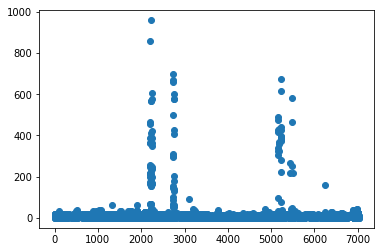

4515            liverpool
4516        livestreaming
4517               living
4518                   lj
4519             ljdrm4d0
4520                   lk
4521                   ll
4522                   lm
4523           lm1kh1gllq
4524               lmorex
4525                 load
4526              loadall
4527    loadcapturecalled
4528               loaded
4529               loader
4530              loading
4531             loadmode
4532        loadmorenews1
4533                  lob
4534                local
4535               locale
4536              locales
4537            localhost
4538         localstorage
4539             location
4540                  log
4541               logged
4542               logger
4543                login
4544            loginnama
              ...        
4985               of7gzc
4986                  off
4987                offer
4988            offerlean
4989     offerleantimeout
4990               office
4991              offline
4992        

In [181]:
vocab = pd.Series(vocab)
vc = vocab[vocab.str.len() <= 1000]
print((vocab.str.len()).describe())
print(len(vc))
Y = vc.str.len()
X = range(len(vc))
plt.scatter(X,Y)
plt.show()
vc[4500:5000]

In [106]:
print(len(vocab))
lst=[]
for w in vocab:
    lst+=word_tokenize(w)
    
print(len(lst))
print(*(lst),sep='\n--------------\n')

14462
14517
!
--------------
#
--------------
$
--------------
%
--------------
&
--------------
'
--------------
''
--------------
'+'hl=zh-cn
--------------
'-1
--------------
'.ga_adstester
--------------
'.loginnama
--------------
'.menu_open
--------------
'//munchkin.marketo.net/munchkin.js
--------------
'//ssl.gstatic.com/gb/images/i1_1967ca6a.png
--------------
'//ssl.gstatic.com/gb/images/i2_2ec824b0.png
--------------
'//www.google-analytics.com/analytics.js
--------------
'//www.googletagmanager.com/gtm.js
--------------
'/21627555768/livedoor_top/pc/main_middle_left
--------------
'/21627555768/livedoor_top/pc/main_middle_right
--------------
'/21627555768/livedoor_top/pc/sbu_1st
--------------
'/7108725/desktop-home-bottombanner
--------------
'/7108725/desktop-home-floating
--------------
'/7108725/desktop-home-leaderboard
--------------
'/7108725/desktop-home-rectangle1
--------------
'/7108725/desktop-home-rectangle2
--------------
'/7108725/desktop-home-rectangle3
---

/cdn-cgi/styles/cf.errors.ie.css
--------------
/center
--------------
/chrome\/
--------------
/cloud-storage
--------------
/cloud-storage/ftp-alternative
--------------
/collaboration/document-management
--------------
/collaboration/project-management
--------------
/collaboration/relay-workflow
--------------
/common-footer
--------------
/content-management/enterprise
--------------
/crios/.test
--------------
/crios\/
--------------
/ct-desktop-top-nav-bar
--------------
/ct-global-notification
--------------
/customer-success/box-consulting
--------------
/customer-success/support-services
--------------
/customer-success/transform
--------------
/customers
--------------
/customers/astrazeneca
--------------
/customers/fico
--------------
/customers/ge
--------------
/d=1/ed=1
--------------
/dd
--------------
/de-de/home
--------------
/departments/engineering
--------------
/departments/finance-accounting
--------------
/departments/human-resources
--------------
/department

_.db=function
--------------
_.dc
--------------
_.dc=function
--------------
_.dd
--------------
_.dd=function
--------------
_.de
--------------
_.de=function
--------------
_.df
--------------
_.df=function
--------------
_.dk
--------------
_.dk=function
--------------
_.dl
--------------
_.dl=
--------------
_.ea
--------------
_.ea=date.now||function
--------------
_.eb
--------------
_.eb=function
--------------
_.ef
--------------
_.ef=function
--------------
_.eg
--------------
_.eg=function
--------------
_.ek=function
--------------
_.el
--------------
_.el=function
--------------
_.f
--------------
_.f=function
--------------
_.fb
--------------
_.fb=_.eb
--------------
_.fb=function
--------------
_.fc
--------------
_.fc=function
--------------
_.fd
--------------
_.fd=function
--------------
_.fe
--------------
_.fe.call
--------------
_.fe.prototype.preventdefault=function
--------------
_.fe.prototype.stoppropagation=function
--------------
_.fe=function
--------------

c=c.nonce||c.getattribute
--------------
c=c.o
--------------
c=c.parentnode
--------------
c=c.queryselector
--------------
c=c.substring
--------------
c=c.tolowercase
--------------
c=c.valueof
--------------
c=ce
--------------
c=c||0
--------------
c=c||_.n
--------------
c=d
--------------
c=d-1
--------------
c=d.childnodes
--------------
c=d.o
--------------
c=d.target||d.srcelement
--------------
c=document.createelement
--------------
c=document.documentelement.getattribute
--------------
c=document.queryselector
--------------
c=e
--------------
c=e.length
--------------
c=error
--------------
c=f
--------------
c=function
--------------
c=g
--------------
c=g.call
--------------
c=google.getlei
--------------
c=h
--------------
c=i
--------------
c=i.p+a
--------------
c=la
--------------
c=m
--------------
c=math.random
--------------
c=nc
--------------
c=new
--------------
c=null
--------------
c=number
--------------
c=object.defineproperty
--------------
c=of
---------

gb_jg
--------------
gb_k
--------------
gb_la
--------------
gb_lf
--------------
gb_m
--------------
gb_mg
--------------
gb_o
--------------
gb_q
--------------
gb_qa-buttonset-default
--------------
gb_r
--------------
gb_ra
--------------
gb_rf
--------------
gb_s
--------------
gb_sa
--------------
gb_t
--------------
gb_td
--------------
gb_tf
--------------
gb_u
--------------
gb_ud
--------------
gb_uf
--------------
gb_v
--------------
gb_va
--------------
gb_w
--------------
gb_x
--------------
gb_z
--------------
gb_zc
--------------
gba
--------------
gba.gb_ba
--------------
gba.gb_fg
--------------
gba.gb_fg.gb_ba
--------------
gba.gb_gg
--------------
gbar
--------------
gbar.abh
--------------
gbar.ach
--------------
gbar.adh
--------------
gbar.aeh
--------------
gbar.bsy
--------------
gbar.bv
--------------
gbar.close
--------------
gbar.cls
--------------
gbar.elr
--------------
gbar.kn
--------------
gbar.ldb
--------------
gbar.mls
--------------
gbar.op
-------

object.values
--------------
objects
--------------
october
--------------
od
--------------
od.prototype.get=function
--------------
od=function
--------------
oe
--------------
oe.prototype.add=function
--------------
oe.prototype.haslistener=function
--------------
oe.prototype.oc=function
--------------
oe.prototype.qb=function
--------------
oe.prototype.remove=function
--------------
oe=function
--------------
of
--------------
of7gzc
--------------
of=function
--------------
off
--------------
offer
--------------
office
--------------
offset
--------------
offsides
--------------
og
--------------
og-
--------------
og.og2.-19gfve72srach.l.x.o
--------------
og.og2.en_us.1bwig6eetwo.o
--------------
og/_/js
--------------
og/_/ss
--------------
ogbl
--------------
oge
--------------
ogex
--------------
ogp
--------------
ogsr
--------------
ogus
--------------
ogw
--------------
oj
--------------
oj=function
--------------
ok
--------------
ok=function
--------------
okezone
--

this.ja=c
--------------
this.ja=this.ja
--------------
this.ja||
--------------
this.json
--------------
this.json||
--------------
this.key=
--------------
this.key=++le
--------------
this.key=++ma
--------------
this.key=a.key||
--------------
this.keycode=a.keycode||0
--------------
this.l
--------------
this.l.call
--------------
this.l.ha
--------------
this.l=
--------------
this.l=0
--------------
this.l=a
--------------
this.l=null
--------------
this.l=void
--------------
this.lb
--------------
this.lb.appendchild
--------------
this.le
--------------
this.length
--------------
this.line=n
--------------
this.listener
--------------
this.listener=a
--------------
this.listener=function
--------------
this.loadcapturecalled||4
--------------
this.log
--------------
this.ma
--------------
this.ma=
--------------
this.message=string
--------------
this.message=t||
--------------
this.metakey=a.metakey
--------------
this.metakey=this.shiftkey=this.altkey=this.ctrlkey=
---------

In [83]:
bigram_measures = nltk.collocations.BigramAssocMeasures()
trigram_measures = nltk.collocations.TrigramAssocMeasures()
print(nltk.BigramCollocationFinder.from_words(words))

In [44]:

print(*(temp.split('\n')),sep='\n-----------\n') #might be useful for intial processing if I want to strip out common lines


-----------

-----------

-----------

-----------

-----------

-----------
   WordPress.com: Create a Free Website or Blog
-----------
  
-----------

-----------

-----------

-----------

-----------

-----------

-----------

-----------

-----------

-----------

-----------

-----------

-----------

-----------

-----------

-----------

-----------

-----------

-----------

-----------

-----------

-----------

-----------

-----------

-----------

-----------

-----------

-----------

-----------

-----------

-----------

-----------

-----------

-----------

-----------

-----------

-----------

-----------

-----------

-----------

-----------

-----------

-----------

-----------

-----------

-----------

-----------

-----------

-----------

-----------

-----------

-----------

-----------

-----------

-----------

-----------

-----------

-----------

-----------

-----------

-----------

-----------

-----------

-----------

-----------

-----------

-

In [24]:

print(*((html_str[v]).split('\n')),sep='\n-----------\n') #might be useful for intial processing if I want to strip out common lines

<!DOCTYPE html>
-----------
<!--[if IE 8]><html id="reset" class="ie8" lang="en"><![endif]-->
-----------
<!--[if IE 9]><html id="reset" class="ie9" lang="en"><![endif]-->
-----------
<!--[if gt IE 9]><!-->
-----------
<html id="reset" lang="en">
-----------
 <!--<![endif]-->
-----------
 <!--[if !IE]><!-->
-----------
 <!--<![endif]-->
-----------
 <head>
-----------
  <meta content="IE=edge" http-equiv="X-UA-Compatible"/>
-----------
  <title>
-----------
   Kijiji - Buy, Sell &amp; Save with Canada's #1 Local Classifieds.
-----------
  </title>
-----------
  <meta content="Visit Kijiji Classifieds to buy, sell, or trade almost anything! New and used items, cars, real estate, jobs, services, vacation rentals and more virtually anywhere in Canada." name="description"/>
-----------
  <meta content="text/html; charset=utf-8" http-equiv="content-type"/>
-----------
  <link href="https://ca.classistatic.com/static/V/8227/img/favicons/apple-touch-icon-new.png" rel="apple-touch-icon" sizes=

         <svg class="icon-459822882 kijijiCentralIcon-2735843417" focusable="false" height="100%" role="img" width="100%">
-----------
          <use xlink:href="#icon-footer-kijijicentral">
-----------
          </use>
-----------
         </svg>
-----------
        </a>
-----------
        <a aria-label="YouTube" class="socialMediaIconContainer-2478597958 youtube-120813017" href="https://www.youtube.com/kijijicanadacorp" rel=" noopener noreferrer" target="_blank" title="Opens in a new window.">
-----------
         <svg class="icon-459822882 youtubeIcon-3637872524" focusable="false" height="100%" role="img" width="100%">
-----------
          <use xlink:href="#icon-footer-youtube">
-----------
          </use>
-----------
         </svg>
-----------
        </a>
-----------
       </div>
-----------
      </div>
-----------
     </div>
-----------
     <div class="copyright-2418027893">
-----------
      <p class="copyrightText-2350281792">
-----------
       <span class="copyrightSy

In [107]:
print(bs4.BeautifulSoup(html_str[v],"lxml").get_text())





   Access denied | jugantor.com used Cloudflare to restrict access
  








   body{margin:0;padding:0}
  












    Please enable cookies.
   




       Error
      

       1010
      

       Ray ID: 4eab3f5b8ebab6cc • 2019-06-22 03:48:35 UTC
      


      Access denied
     









        What happened?
       

        The owner of this website (jugantor.com) has banned your access based on your browser's signature (4eab3f5b8ebab6cc-ua98).
       







       Cloudflare Ray ID:
       
        4eab3f5b8ebab6cc
       


       •
      


        Your IP
       
       : 178.17.170.135
      

       •
      


        Performance & security by
       

        Cloudflare
       









   window._cf_translation = {};
  





#### Possible Ways to featurize HTML String
- line count ie \n or \\n count
- len of base string
- count of different tags
    - meta
    - style
    - script
- counts using regexs 
    - emails
    - links
    - non-ascii characters
- difference in len of string with vs without tags

In [ ]:
#assuming html_str is the a singular string
import re


# # of lines should be approximately equal to # of \n's + # of ;'s inside script tags'